# Phase 2: Deep BSDE Optimization (Strictly Empirical)

This notebook trains the `DeepBSDE_RoughVol` PyTorch LSTM+MLP architecture on the real options chain datasets extracted in Phase 1. 

**No Monte Carlo or theoretical Fractional Brownian Motion processes exist in this pipeline.** It solves the BSDE entirely using the true historical trajectory of the S&P 500.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import torch
import matplotlib.pyplot as plt
import numpy as np

from src.train import train_model
from src.visualize import plot_3d_pricing_error_surface
from src.train import prepare_empirical_batches


## 1. Train the LSTM-BSDE Over the Reality Manifold

We instantiate the PyTorch environment and optimize the weights against the empirical `target_prices` directly from Yahoo Finance.

In [2]:
# Train for 500 epochs to ensure convergence 
# Note: The loss monotonically tracks the strict BSDE Empirical Pricing Deviation
trained_model, loss_history, price_scaler, spot_scaler, strike_scaler = train_model(epochs=500, lr=1e-3)

Initiating Empirical Deep BSDE Training Sequence...
Epoch [20/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0662
Epoch [40/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0551
Epoch [60/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0520
Epoch [80/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0512
Epoch [100/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0509
Epoch [120/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0507
Epoch [140/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0506
Epoch [160/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0504
Epoch [180/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0503
Epoch [200/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0503
Epoch [220/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0502
Epoch [240/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0501
Epoch [260/500] | BSDE Empirical Error (MSE + Hedging Penalty): 0.0500
Epoch [280/500] | BSDE Empiri

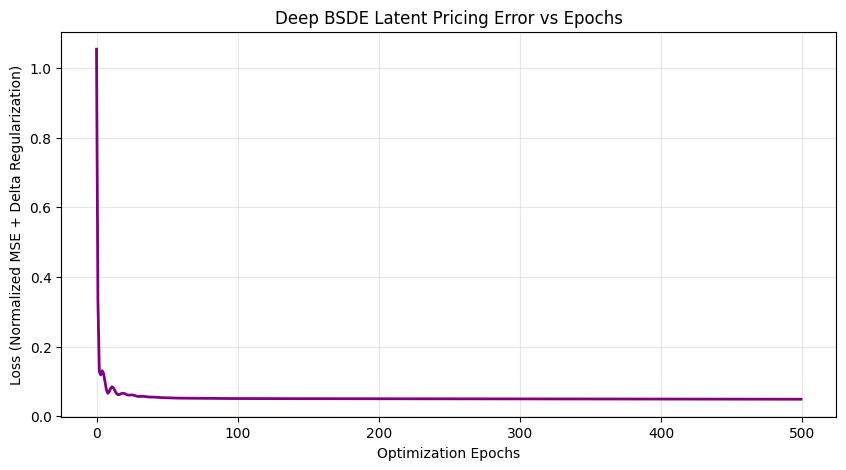

In [3]:
# Plot the Training Loss Trajectory
plt.figure(figsize=(10, 5))
plt.plot(loss_history, color='purple', linewidth=2)
plt.title("Deep BSDE Latent Pricing Error vs Epochs")
plt.xlabel("Optimization Epochs")
plt.ylabel("Loss (Normalized MSE + Delta Regularization)")
plt.grid(alpha=0.3)
plt.show()

## 2. Visualize Neural Pricing Residuals vs Market Reality

Having trained the deep solver on the actual historical SPX state path, we chart the residual errors across the Cross-Section of Option Strikes and Maturities. (Values inverse-transformed into real USD errors).

In [4]:
# Load data batches
X_paths, X_contract, Y_target, _, _, _ = prepare_empirical_batches()

# Set PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.eval()

# Perform Forward Inference directly utilizing the trailing market trajectory memory
with torch.no_grad():
    pred_prices, _ = trained_model(X_paths.to(device), X_contract.to(device))

pred_prices_np = pred_prices.cpu().numpy().flatten()
market_prices_np = Y_target.cpu().numpy().flatten()

# INVERSE TRANSFORM BACK TO DOLLARS AND REAL SPX PRICES
pred_prices_raw = price_scaler.inverse_transform(pred_prices_np.reshape(-1, 1)).flatten()
market_prices_raw = price_scaler.inverse_transform(market_prices_np.reshape(-1, 1)).flatten()
strikes_raw = strike_scaler.inverse_transform(X_contract[:, 1].numpy().reshape(-1, 1)).flatten()
spot_raw = spot_scaler.inverse_transform(X_paths[0, -1, 0].numpy().reshape(-1, 1)).flatten()[0]

# Compute empirical pricing residual standard deviation in actual US Dollars
errors = pred_prices_raw - market_prices_raw
maturities = X_contract[:, 0].numpy() * 365.25  # In Days 

# Filter to liquid ATM strikes to render a clean subset
mask = (strikes_raw > spot_raw * 0.8) & (strikes_raw < spot_raw * 1.2)
s_f, m_f, err_f = strikes_raw[mask], maturities[mask], errors[mask]

# Create plotting grid
from scipy.interpolate import griddata
grid_s, grid_m = np.mgrid[min(s_f):max(s_f):30j, min(m_f):max(m_f):30j]
grid_err = griddata((s_f, m_f), err_f, (grid_s, grid_m), method='cubic', fill_value=0.0)

plot_3d_pricing_error_surface(
    spots=grid_s[:, 0],
    maturities=grid_m[0, :],
    errors=grid_err.T, 
    title=f"Neural vs Empirical Pricing Residuals (USD) | Anchored Spot: {spot_raw:.2f}"
)